# Analyse des données Covid disponibles en Open Data

## Sommaire : 

- Import des données 
    * données geographiques des régions
    * données covid quotidiennes par departement
    * données indexs entre departements et regions
    * données covid mondiales

- Données France
    * Nombre de nouveaux cas par jour 
    * Evolution du nb de cas par jour / region
    * Proliferation des cas sur la carte francaise
  
- Données Monde 
    * Evolution du nb de cas par pays 
    * XXXX
    * YYYY


In [73]:
import pandas as pd
import numpy as np
import requests
import io
import os
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker
import numpy as np
from matplotlib.animation import FuncAnimation
import geopandas as gpd
%matplotlib inline
%matplotlib notebook
from matplotlib import animation, rc
from IPython.display import HTML
from matplotlib.colors import LinearSegmentedColormap

Traceback (most recent call last):
  File "C:\Users\Avisia\anaconda3\envs\my_python_env\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\Avisia\anaconda3\envs\my_python_env\lib\site-packages\matplotlib\animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


## Import des données

* ###  données geographiques des régions

In [74]:
url_reg = r"http://osm13.openstreetmap.fr/~cquest/openfla/export/regions-20161121-shp.zip"
map_df = gpd.read_file(url_reg)
map_df = map_df.iloc[5:].sort_values('name')
map_df = map_df[['name','code_insee','geometry']]
map_df['population'] = [8032377,2783039,3340379,2559073,344679,5511747,5962662,3303500,5999982,5924858,3801797,5055651,12278210]
map_df.head(3)

,name,code_insee,geometry,population
15,Auvergne-Rhône-Alpes,84,"POLYGON ((2.06290 44.97664, 2.06355 44.97666, ...",8032377
7,Bourgogne-Franche-Comté,27,"POLYGON ((2.84448 47.54488, 2.84596 47.54546, ...",2783039
12,Bretagne,53,"MULTIPOLYGON (((-4.79544 48.41415, -4.79543 48...",3340379


- ### données covid quotidiennes par departement

In [75]:
url = "https://www.data.gouv.fr/fr/datasets/r/6fadff46-9efd-4c53-942a-54aca783c30c"
s = requests.get(url).content

covid_df = pd.read_csv(io.StringIO(s.decode('utf-8')), sep = ";")
covid_df.rename(columns={"incid_rad": "guerison", "incid_dc": "deces", "incid_rea": "reanimation", "incid_hosp": "hospitalisation"},inplace=True)
covid_df.head(3)

,dep,jour,hospitalisation,reanimation,deces,guerison
0,01,2020-03-19,1,0,0,0
1,01,2020-03-20,0,0,0,1
2,01,2020-03-21,4,0,0,0


- ### données indexs entre departements et regions

In [76]:
url = "https://public.opendatasoft.com/explore/dataset/code-officiel-geographique-2019-regions-et-departement/download/?format=csv&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true&csv_separator=%3B"
s = requests.get(url).content

dep_reg_df = pd.read_csv(io.StringIO(s.decode('utf-8')), sep = ";")
dep_reg_df = dep_reg_df[['Code INSEE Département','Nom Département','Code INSEE Région','Nom région']]
dep_reg_df.rename(columns={"Code INSEE Département": "code_dep", "Code INSEE Région": "code_reg"},inplace=True)
dep_reg_df.head(3)

,code_dep,Nom Département,code_reg,Nom région
0,06,Alpes-Maritimes,93,Provence-Alpes-Côte d'Azur
1,25,Doubs,27,Bourgogne-Franche-Comté
2,58,Nièvre,27,Bourgogne-Franche-Comté


- ### données covid mondiales

In [77]:
df = pd.read_csv('https://raw.githubusercontent.com/datasets/covid-19/master/data/countries-aggregated.csv', parse_dates=['Date'])
countries = [ 'Germany', 'United Kingdom', 'US', 'France', 'China','Italy','Spain']
df = df[df['Country'].isin(countries)]


df['Cases'] = df[['Confirmed', 'Recovered', 'Deaths']].sum(axis=1)

## Données France

Pour enrichir nos données pour la suite nous allons joindre les données cas/jour/departement avec les données departement/region, mais aussi creer un dataset regroupant les cas/jour/region et les cas/region

In [78]:
covid_df = covid_df.join(dep_reg_df.set_index('code_dep'), on='dep', how='outer')
covid_df.sort_values(['jour'],ascending=False).head(3)
covid_region = covid_df.groupby(['Nom région','code_reg'],as_index=False).sum().sort_values('deces', ascending=False)
covid_region_day =  covid_df.groupby(['jour','Nom région','code_reg'],as_index=False).sum().sort_values('jour', ascending=False)

- ### Nombre de nouveaux cas par jour

<IPython.core.display.Javascript object>


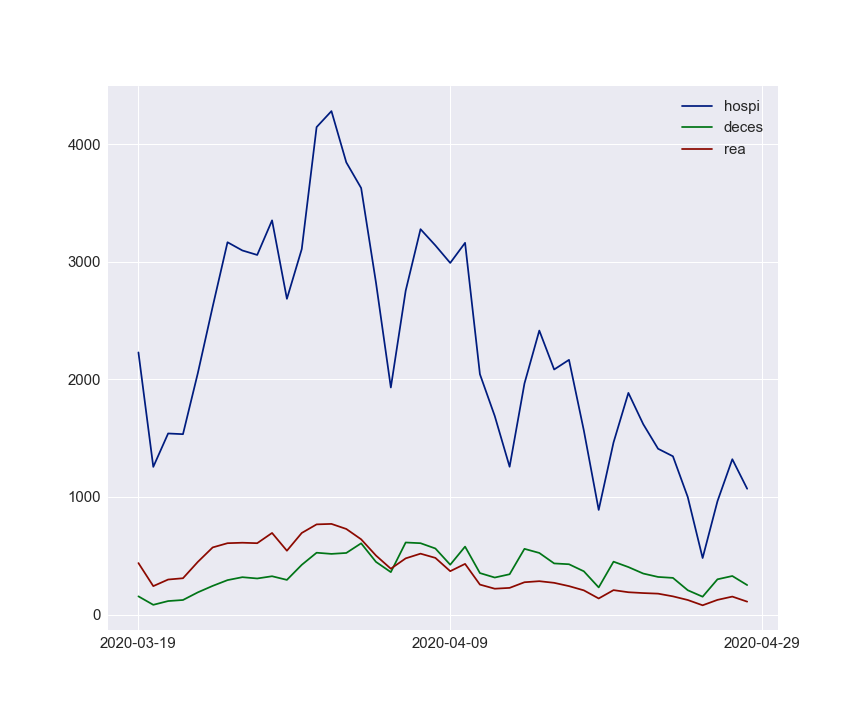

In [79]:
# on regroupe les totaux d'hospitalisation,reanimation etc par jour pour notre futur graphe
covid_day =  covid_df.groupby(['jour'],as_index=False).sum().sort_values('jour', ascending=False).sort_values('jour', ascending=True)
positions = [0,len(covid_day)//2,len(covid_day)]
labels = [covid_day['jour'].iat[0],covid_day['jour'].iat[len(covid_day)//2],covid_day['jour'].iat[-1]]
# creation des lines correspondantes a chaque type de cas
plt.figure(figsize=(12,10))
plt.tick_params(labelsize=15)
hospi_line, =plt.plot(covid_day['hospitalisation'],label = 'hospi') 
deces_line, = plt.plot(covid_day['deces'],label = 'deces') 
rea_line,= plt.plot(covid_day['reanimation'],label = 'rea') 

#creation du graphe

plt.xticks(positions, labels)
plt.legend(handles=[hospi_line, deces_line,rea_line], prop={'size': 15})
plt.show()

- ## Evolution du nb de cas par jour / region


- ## Proliferation des cas sur la carte francaise

In [80]:
# cast des types pour qu'ils soient identiques lors de la jointure
map_df['code_insee'] = map_df['code_insee'].astype(int)
covid_region['code_reg'] = covid_region['code_reg'].astype(int)
covid_region_day['code_reg'] = covid_region_day['code_reg'].astype(int)

In [81]:
merged = map_df.join(covid_region.set_index('code_reg'), on = "code_insee")
merged['total']= merged['deces'] + merged['hospitalisation'] + merged['reanimation'] 

In [82]:
merged_evo = covid_region_day.set_index('code_reg').join(map_df.set_index('code_insee'), on = "code_reg",how = "left")
merged_evo['total']= merged_evo['deces'] + merged_evo['hospitalisation'] + merged_evo['reanimation'] 

In [83]:
# save all the maps in the charts folder
output_path = 'charts\maps'
merged_evo = merged_evo.sort_values(['code_reg','jour'])
merged_evo['cum_sum_total'] = merged_evo.groupby(['code_reg'])['total'].cumsum()
merged_evo['pourcentage_pop'] = (merged_evo['cum_sum_total'] / merged_evo['population'] )*100
list_of_days = merged_evo['jour'].drop_duplicates()

merged_evo[['Nom région','jour','deces','hospitalisation','reanimation','total','population','cum_sum_total','pourcentage_pop']].sort_values(['code_reg','jour']).tail(5)


,Nom région,jour,deces,hospitalisation,reanimation,total,population,cum_sum_total,pourcentage_pop
code_reg,,,,,,,,,
94,Corse,2020-04-25,1,0,0,1,344679.0,482,0.139840
94,Corse,2020-04-26,0,0,0,0,344679.0,482,0.139840
94,Corse,2020-04-27,0,0,0,0,344679.0,482,0.139840
94,Corse,2020-04-28,0,5,1,6,344679.0,488,0.141581
94,Corse,2020-04-29,0,2,0,2,344679.0,490,0.142161


<IPython.core.display.Javascript object>


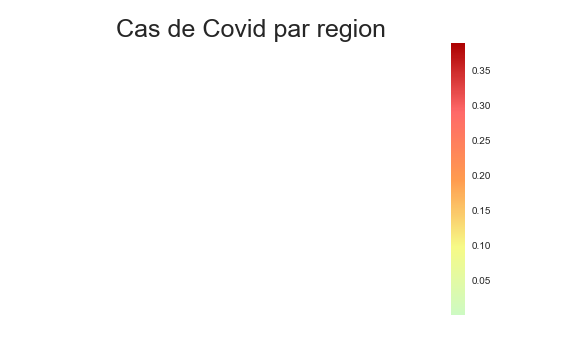

<IPython.core.display.Javascript object>


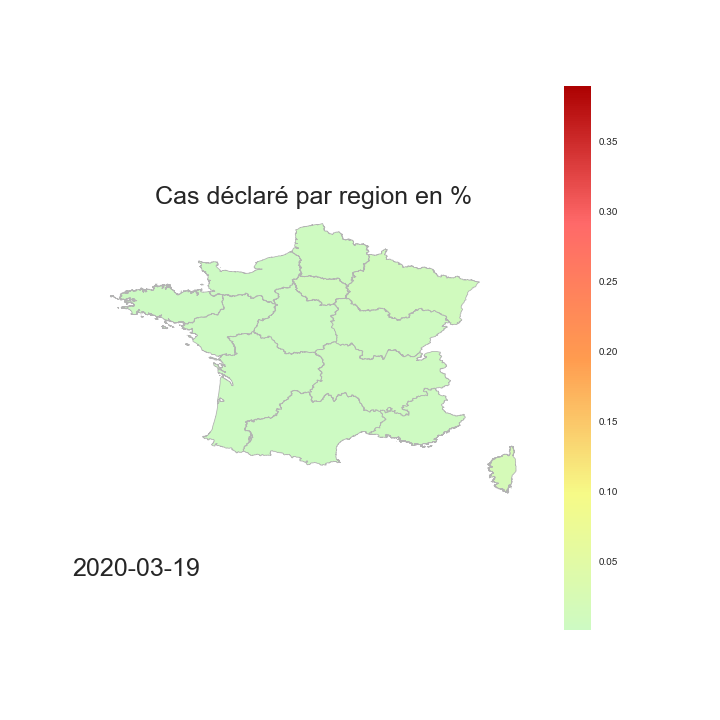

<IPython.core.display.Javascript object>


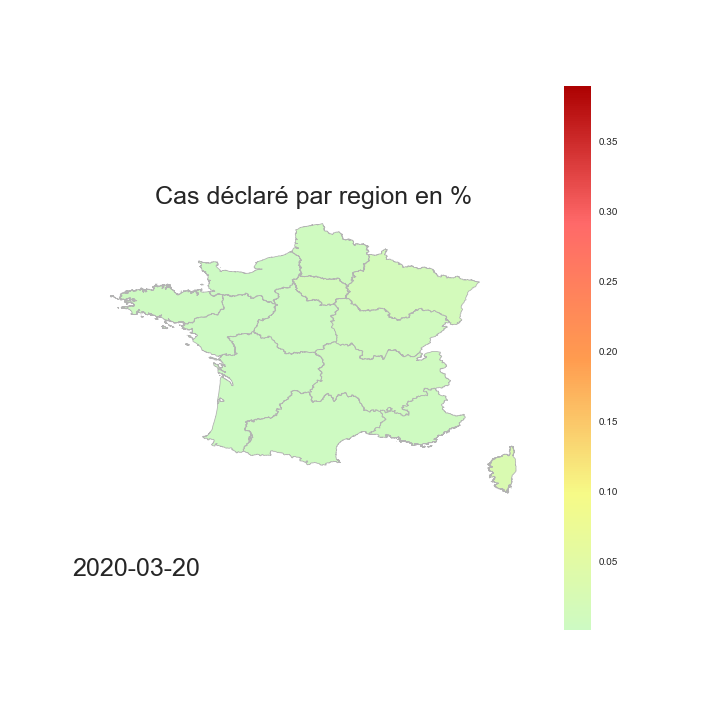

<IPython.core.display.Javascript object>


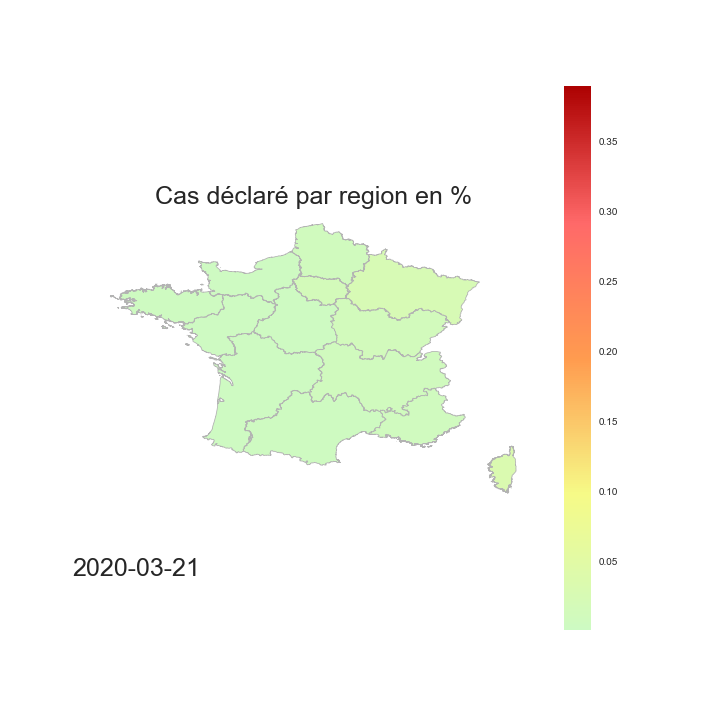

<IPython.core.display.Javascript object>


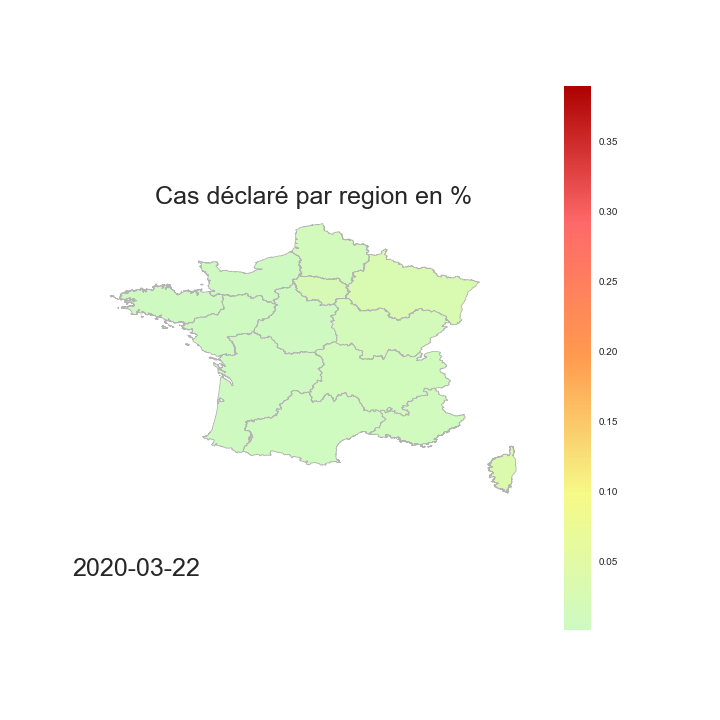

<IPython.core.display.Javascript object>


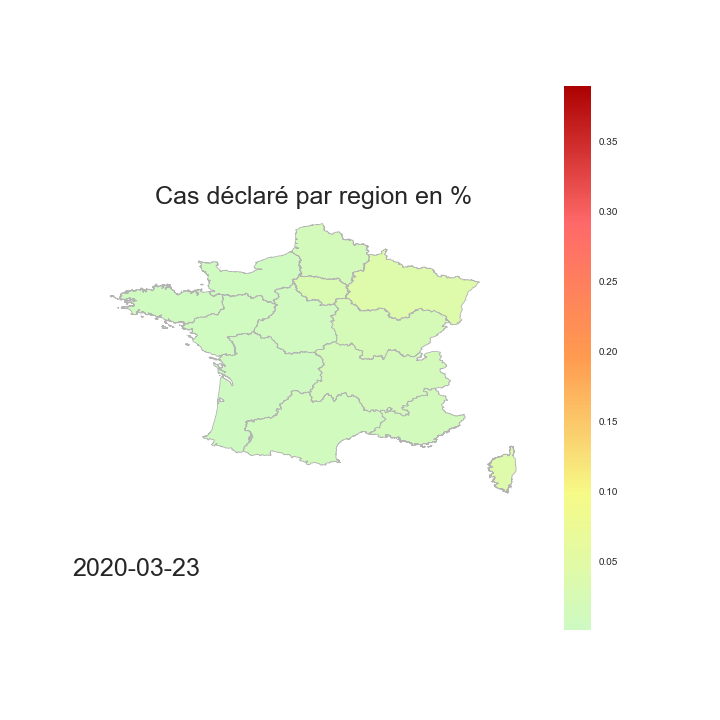

<IPython.core.display.Javascript object>


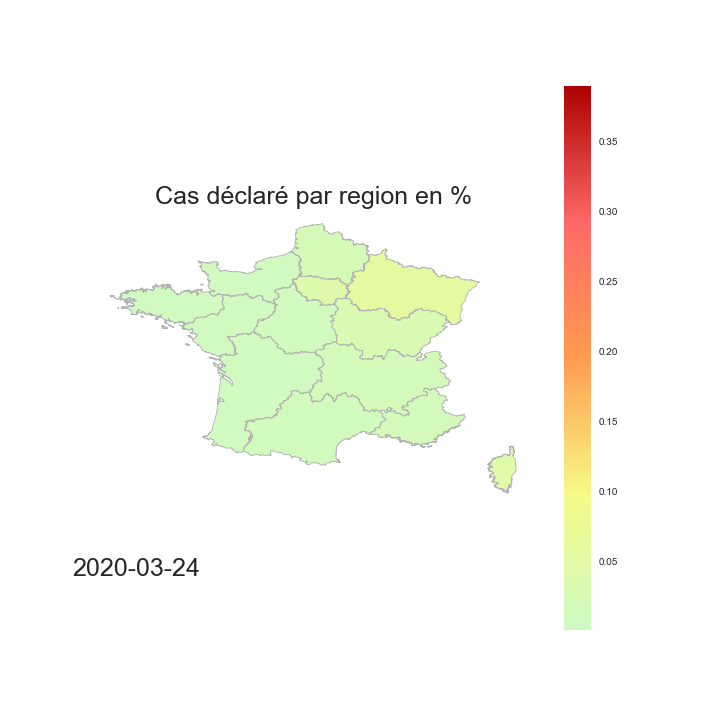

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

C:\Users\Avisia\anaconda3\envs\my_python_env\lib\site-packages\geopandas\plotting.py:480: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


<IPython.core.display.Javascript object>

C:\Users\Avisia\anaconda3\envs\my_python_env\lib\site-packages\geopandas\plotting.py:480: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


<IPython.core.display.Javascript object>

C:\Users\Avisia\anaconda3\envs\my_python_env\lib\site-packages\geopandas\plotting.py:480: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


<IPython.core.display.Javascript object>

C:\Users\Avisia\anaconda3\envs\my_python_env\lib\site-packages\geopandas\plotting.py:480: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


<IPython.core.display.Javascript object>

C:\Users\Avisia\anaconda3\envs\my_python_env\lib\site-packages\geopandas\plotting.py:480: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


<IPython.core.display.Javascript object>

C:\Users\Avisia\anaconda3\envs\my_python_env\lib\site-packages\geopandas\plotting.py:480: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


<IPython.core.display.Javascript object>

C:\Users\Avisia\anaconda3\envs\my_python_env\lib\site-packages\geopandas\plotting.py:480: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


<IPython.core.display.Javascript object>

C:\Users\Avisia\anaconda3\envs\my_python_env\lib\site-packages\geopandas\plotting.py:480: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


<IPython.core.display.Javascript object>

C:\Users\Avisia\anaconda3\envs\my_python_env\lib\site-packages\geopandas\plotting.py:480: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


<IPython.core.display.Javascript object>

C:\Users\Avisia\anaconda3\envs\my_python_env\lib\site-packages\geopandas\plotting.py:480: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


<IPython.core.display.Javascript object>

C:\Users\Avisia\anaconda3\envs\my_python_env\lib\site-packages\geopandas\plotting.py:480: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


<IPython.core.display.Javascript object>

C:\Users\Avisia\anaconda3\envs\my_python_env\lib\site-packages\geopandas\plotting.py:480: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


<IPython.core.display.Javascript object>

C:\Users\Avisia\anaconda3\envs\my_python_env\lib\site-packages\geopandas\plotting.py:480: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


<IPython.core.display.Javascript object>

C:\Users\Avisia\anaconda3\envs\my_python_env\lib\site-packages\geopandas\plotting.py:480: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


<IPython.core.display.Javascript object>

C:\Users\Avisia\anaconda3\envs\my_python_env\lib\site-packages\geopandas\plotting.py:480: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


<IPython.core.display.Javascript object>

C:\Users\Avisia\anaconda3\envs\my_python_env\lib\site-packages\geopandas\plotting.py:480: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


<IPython.core.display.Javascript object>

C:\Users\Avisia\anaconda3\envs\my_python_env\lib\site-packages\geopandas\plotting.py:480: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


<IPython.core.display.Javascript object>

C:\Users\Avisia\anaconda3\envs\my_python_env\lib\site-packages\geopandas\plotting.py:480: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


<IPython.core.display.Javascript object>

C:\Users\Avisia\anaconda3\envs\my_python_env\lib\site-packages\geopandas\plotting.py:480: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


<IPython.core.display.Javascript object>

C:\Users\Avisia\anaconda3\envs\my_python_env\lib\site-packages\geopandas\plotting.py:480: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


<IPython.core.display.Javascript object>

C:\Users\Avisia\anaconda3\envs\my_python_env\lib\site-packages\geopandas\plotting.py:480: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


<IPython.core.display.Javascript object>

C:\Users\Avisia\anaconda3\envs\my_python_env\lib\site-packages\geopandas\plotting.py:480: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


<IPython.core.display.Javascript object>

C:\Users\Avisia\anaconda3\envs\my_python_env\lib\site-packages\geopandas\plotting.py:480: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


<IPython.core.display.Javascript object>

C:\Users\Avisia\anaconda3\envs\my_python_env\lib\site-packages\geopandas\plotting.py:480: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


<IPython.core.display.Javascript object>

In [84]:
#creation plot et style
fig, ax = plt.subplots(1, figsize=(8, 5))
ax.axis('off')
vmin, vmax = merged_evo['pourcentage_pop'].min(), merged_evo['pourcentage_pop'].max()
ax.set_title('Cas de Covid par region', fontdict={'fontsize': '25', 'fontweight' : '3'})
# creation d'un gradient de couleur personalisé alant du vert au rouge 
cmap = LinearSegmentedColormap.from_list('mycmap', ['#cdfac3','#f6fa87', '#ff9b4f', '#ff6969','#ad0202'])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)

for day in list_of_days:
    
    df = gpd.GeoDataFrame(merged_evo[merged_evo['jour']== day ])
    
    fig = df.plot(column='pourcentage_pop', cmap=cmap, figsize=(10,10), linewidth=0.8, edgecolor='0.7', vmin=vmin, vmax=vmax, legend=True, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    
    fig.axis('off')
    fig.set_title('Cas déclaré par region en %', \
              fontdict={'fontsize': '25',
                         'fontweight' : '3'})
    # modification du jour sur le chart
    fig.annotate(day,
            xy=(0.1, .225), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=25)
    
    # creation d'un graphe par jour pour les assembler dans un gif avec ImageMagick
    filepath = os.path.join(output_path, day+'_covid.png')
    chart = fig.get_figure()
    chart.savefig(filepath, dpi=300)

## Données mondiales

- ### Evolution du nb de cas par pays 


In [85]:
y_data = []
# creation d'une liste contenant les données pour chaque pays pour tracer une seule ligne par pays
for country in countries :
    y_data.append(df.sort_values(by=['Date'], ascending=True).loc[df['Country']==country,['Cases']].reset_index(drop=True))

x_data = y_data[0].index.values.tolist() 
y_max = 0

# recuperation de la valeur max en y pour les axes du chart
for pays in y_data : 
    if (y_max < pays['Cases'].iat[-1]) :
        y_max = pays['Cases'].iat[-1]
        

KeyError: 'Date'

In [ ]:
plt.style.use('seaborn-dark-palette')
fig = plt.figure(figsize=(12,12))
ax = plt.axes(xlim=(0, len(x_data)), ylim=(0, y_max))
lines = [plt.plot([], [],linewidth=4)[0] for _ in range(7)]
ax.legend(lines, countries, loc='upper left', shadow=True, prop={'size': 15})
plt.tick_params(labelsize=15)
def init():
    lines[0].set_data([], [])
    return lines
def animate(i):
    
    for j in range (1,len(countries)) :
        lines[j-1].set_data( x_data[:i], y_data[j-1][:i])
    
   
    
    return lines

anim = FuncAnimation(fig, animate, init_func=init,repeat =True,frames=len(x_data), interval=100, blit=False)
HTML(anim.to_jshtml())
